In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
np.random.seed(42)
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
folder_benign_train = '/content/drive/MyDrive/MachineLearning_dataset/data/train/benign'
folder_malignant_train = '/content/drive/MyDrive/MachineLearning_dataset/data/train/malignant'

folder_benign_test = '/content/drive/MyDrive/MachineLearning_dataset/data/test/benign'
folder_malignant_test = '/content/drive/MyDrive/MachineLearning_dataset/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
Y_benign = np.zeros(X_benign.shape[0])
Y_malignant = np.ones(X_malignant.shape[0])

Y_benign_test = np.zeros(X_benign_test.shape[0])
Y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
Y_train = np.concatenate((Y_benign, Y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
Y_test = np.concatenate((Y_benign_test, Y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

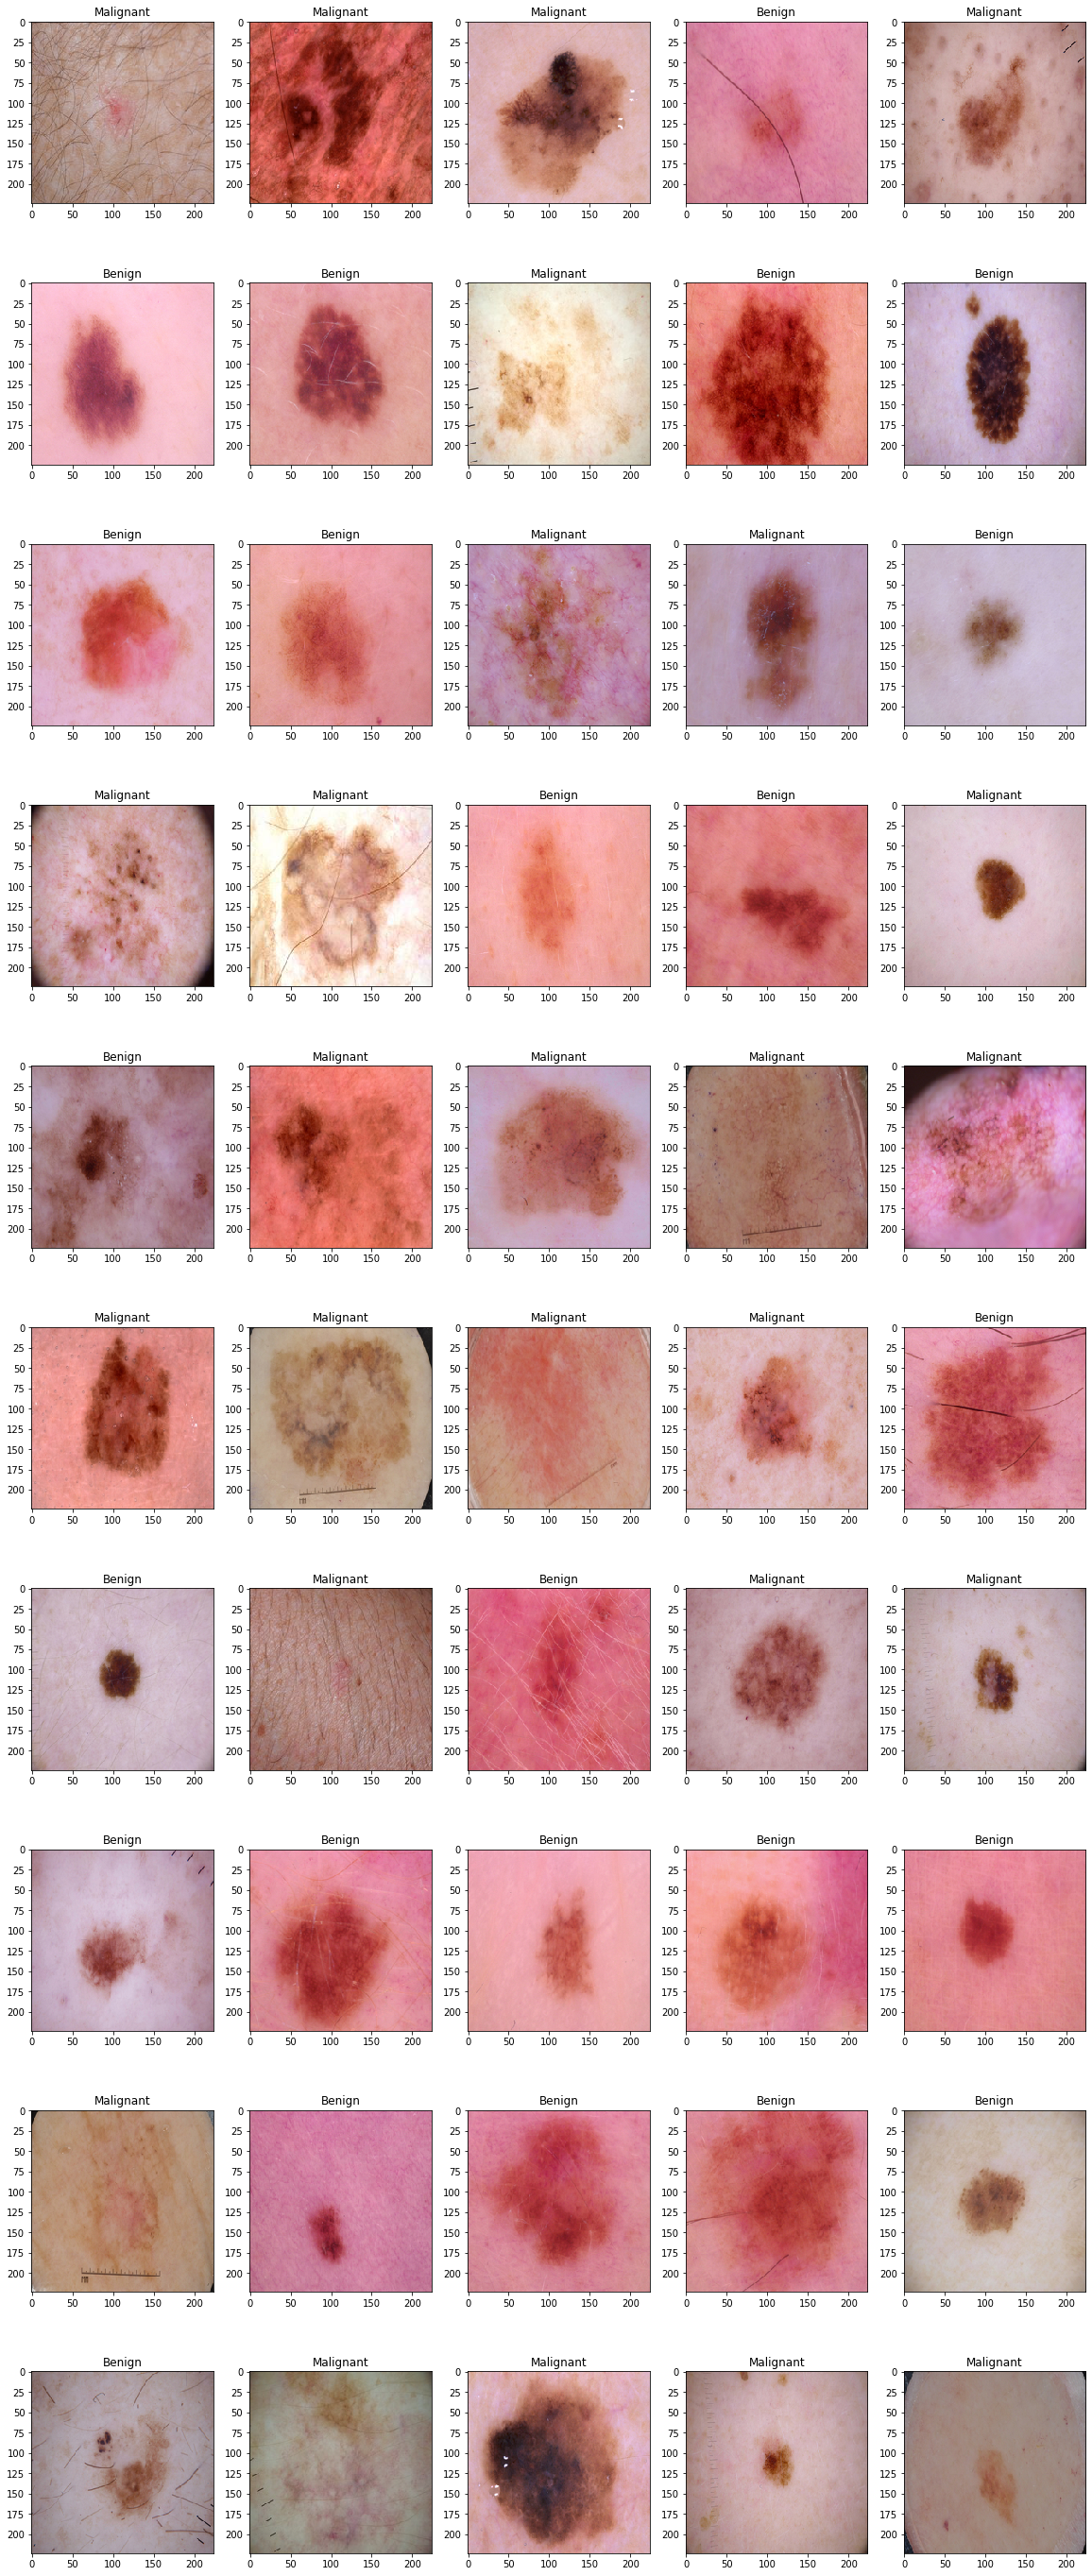

In [ ]:
fig=plt.figure(figsize=(20, 50))
columns = 5
rows = 10

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [ ]:
print('Shapes: \n')
print('X_train: ',X_train.shape,' \n')
print('Y_train: ',Y_train.shape,' \n')
print('X_test : ',X_test.shape,' \n')
print('Y_test : ',Y_test.shape,' \n')
print('Y_train malginant Distrib: ',(Y_train.sum()/len(Y_train)).round(4), '\n')
print('Y_test malginant Distrib: ',(Y_test.sum()/len(Y_test)).round(4), '\n')

Shapes: 

X_train:  (2637, 224, 224, 3)  

Y_train:  (2637,)  

X_test :  (660, 224, 224, 3)  

Y_test :  (660,)  

Y_train malginant Distrib:  0.4539 

Y_test malginant Distrib:  0.4545 



In [ ]:
#Subsampling to prior CNN model evaluation
Sample1 = np.random.choice(range(0,len(X_train)), size=1000, replace=False)
Sample1
Sample2 = np.random.choice(range(0,len(X_test)), size=600, replace=False)
Sample2

array([373, 230, 561, 556, 645, 370, 517, 261, 446, 651, 389, 301, 280,
       353, 498,  45, 613, 527, 403, 571, 399,  79, 650,   0, 123, 609,
       224, 282,  62, 141, 451, 429,  97, 503, 122, 161, 222, 494, 414,
       470, 439, 112, 165, 240, 172, 201, 168, 146,  36, 139, 260, 576,
       602, 605, 375, 226, 418, 295, 227, 160, 565, 523,  16, 378,  94,
       402, 135, 140, 435, 183, 491, 274, 157, 138,  82, 608, 510, 540,
        63, 197, 231, 129, 417, 182, 323, 193, 216, 575, 434, 124, 306,
       192, 374, 107, 578,  25,  37,  98, 205, 391, 204, 327, 614,  27,
       144,  44, 283, 120,  51, 286, 457, 590, 504, 185, 562,  60, 629,
       221, 269, 449, 437, 142, 242, 648, 625, 270, 314, 649, 152, 121,
       419, 496, 365, 307, 147, 656, 273, 557,  73, 108, 194, 452,  67,
       647, 392, 312, 176,  17,  40, 515, 641, 178,  61, 246, 459, 200,
       606, 574, 536, 655, 243, 635, 646, 482, 563, 600, 484, 604, 455,
       509, 181, 545, 530, 546, 612,  78, 579,  84, 552, 569, 19

In [ ]:
X_train_sample = X_train[Sample1]
Y_train_sample = Y_train[Sample1]
X_test_sample = X_test[Sample2]
Y_test_sample = Y_test[Sample2]

In [ ]:
X_train_sample.shape

(1000, 224, 224, 3)

In [ ]:
Y_train_sample.shape

(1000,)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
# Final
num_classes = 1
SIZE = 224           
kern_size = 3


model3 = Sequential()
model3.add(Conv2D(filters=50, kernel_size=(kern_size, kern_size), activation="relu", input_shape=(SIZE, SIZE, 3)))
model3.add(MaxPool2D(pool_size=(2, 2)))  
model3.add(Dropout(0.3))

model3.add(Conv2D(filters=20, kernel_size=(kern_size, kern_size), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))  
model3.add(Dropout(0.3))

model3.add(Conv2D(filters=20, kernel_size=(kern_size, kern_size),activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))  
model3.add(Dropout(0.3))

model3.add(Flatten())

model3.add(Dense(100,activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(50,activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["BinaryAccuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 50)      1400      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 50)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 111, 111, 50)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 20)      9020      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 20)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 54, 54, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 20)       

In [ ]:
# Fine tunning
# Running model in all data
batch_size = 20
epochs = 18

history3 = model3.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_test, Y_test),
    verbose=2,
    callbacks=[ModelCheckpoint("SequentialModel3.h5", monitor='val_binary_accuracy',save_weights_only=True, mode='max', save_best_only=True, verbose=2)])

Epoch 1/18
132/132 - 41s - loss: 7.7944 - binary_accuracy: 0.5218 - val_loss: 0.6967 - val_binary_accuracy: 0.4803

Epoch 00001: val_binary_accuracy improved from -inf to 0.48030, saving model to SequentialModel3.h5
Epoch 2/18
132/132 - 4s - loss: 0.6976 - binary_accuracy: 0.5681 - val_loss: 0.6944 - val_binary_accuracy: 0.4545

Epoch 00002: val_binary_accuracy did not improve from 0.48030
Epoch 3/18
132/132 - 4s - loss: 0.6865 - binary_accuracy: 0.5586 - val_loss: 0.6948 - val_binary_accuracy: 0.4545

Epoch 00003: val_binary_accuracy did not improve from 0.48030
Epoch 4/18
132/132 - 4s - loss: 0.6208 - binary_accuracy: 0.6405 - val_loss: 0.5549 - val_binary_accuracy: 0.7348

Epoch 00004: val_binary_accuracy improved from 0.48030 to 0.73485, saving model to SequentialModel3.h5
Epoch 5/18
132/132 - 4s - loss: 0.6007 - binary_accuracy: 0.6708 - val_loss: 0.5866 - val_binary_accuracy: 0.7500

Epoch 00005: val_binary_accuracy improved from 0.73485 to 0.75000, saving model to SequentialMode

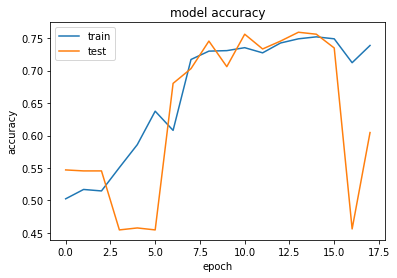

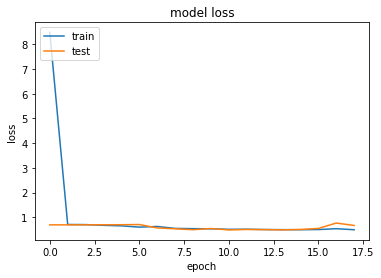

In [ ]:
plt.plot(history3.history['binary_accuracy'])
plt.plot(history3.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()